# Module 12: Classification with Naive Bayes

* DS 5001
* Raf Alvarado

We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.

# Set Up

## Configure

In [2]:
src_file = 'winereviews.csv'

# Set Hyperparameters
class Params():
    qntile_P = .9
    qntile_N = .1
    n_sets = 4
    smooth_alpha = .1
    binary_mode = True
params = Params()

## Import

In [3]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import textman as tx

## Pragmas

In [4]:
%matplotlib inline

# Process

## PREPARATION

### Import wine reviews

In [5]:
docs = pd.read_csv('winereviews.csv', index_col='doc_id')

In [6]:
docs.head()

,doc_content,points
doc_id,,
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


### Convert points to labels

#### Keep only reviews with high and low ratings

In [7]:
bound_P = int(docs['points'].quantile(params.qntile_P))
bound_N = int(docs['points'].quantile(params.qntile_N))
docs = docs[(docs.points <= bound_N) | (docs.points >= bound_P)]

In [8]:
docs.sample(5)

,doc_content,points
doc_id,,
70349,Juicy Fruit gum and citrus blossom meet a chem...,83
87297,"Very pure in character, a wine that expresses ...",94
11862,"Juicy and fruity, with red berry fruits and a ...",84
89723,Aromas of sawmill and burnt wood are dominant....,81
47358,"Initially subdued, the fresh-fruited ripeness ...",93


#### Assign labels for high and low

In [9]:
docs.loc[docs['points'] >= bound_P, 'doc_label'] = 'P'
docs.loc[docs['points'] <= bound_N, 'doc_label'] = 'N'

In [10]:
docs.head()

,doc_content,points,doc_label
doc_id,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",83,N
337,"An easy and inviting selection, there's a ment...",83,N
338,The wine is earthy and somewhat rustic. There ...,82,N
339,"Red in color, with berry and apple aromas, thi...",82,N
340,"The nose is muted, despite the slight spritz o...",82,N


In [11]:
docs = docs.drop('points', 1)

In [12]:
docs.head()

,doc_content,doc_label
doc_id,,
336,"Gritty, heavily roasted aromas of peanuts and ...",N
337,"An easy and inviting selection, there's a ment...",N
338,The wine is earthy and somewhat rustic. There ...,N
339,"Red in color, with berry and apple aromas, thi...",N
340,"The nose is muted, despite the slight spritz o...",N


### Divide docs into train and test sets

#### Assign random numbers to docs

In [13]:
docs['set'] = randint(0,params.n_sets, len(docs.index))

In [14]:
docs.head()

,doc_content,doc_label,set
doc_id,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",N,1
337,"An easy and inviting selection, there's a ment...",N,0
338,The wine is earthy and somewhat rustic. There ...,N,1
339,"Red in color, with berry and apple aromas, thi...",N,1
340,"The nose is muted, despite the slight spritz o...",N,2


#### Split docs by assigned number 

In [15]:
training_docs = docs[docs.set != 0].copy()
testing_docs = docs[docs.set == 0].copy()
del(docs)

In [16]:
training_docs = training_docs.drop('set', 1)
testing_docs = testing_docs.drop('set', 1)

In [19]:
round(len(training_docs) / len(testing_docs), 2)

2.97

### Convert docs to tokens

In [20]:
training_tokens, vocab = tx.create_tokens_and_vocab(training_docs, src_col='doc_content')
testing_tokens, _ = tx.create_tokens_and_vocab(testing_docs, src_col='doc_content')

In [21]:
training_tokens.head()

token term_str  term_id
doc_id sent_id token_id                           
336    0       0          Gritty   gritty     6435
               1         heavily  heavily     6694
               2         roasted  roasted    11724
               3          aromas   aromas      997
               5         peanuts  peanuts    10103

### Apply training vocab to testing

This is **crucial**.

In [23]:
testing_tokens['term_id'] = testing_tokens.term_str.map(vocab.reset_index().set_index('term_str').term_id)

In [28]:
# testing_tokens[testing_tokens.term_id.isna()]

In [31]:
testing_tokens = testing_tokens.dropna().copy()
testing_tokens['term_id'] = testing_tokens['term_id'].astype('int')

In [33]:
testing_tokens.head()

token   term_str  term_id
doc_id sent_id token_id                               
337    0       1              easy       easy     4614
               3          inviting   inviting     7361
               4         selection  selection    12318
               9            streak     streak    13396
               12             soft       soft    12884

#### Simplify tokens table 

In [34]:
training_tokens = training_tokens.reset_index()[['doc_id','term_id']]
testing_tokens = testing_tokens.reset_index()[['doc_id','term_id']]

In [35]:
if params.binary_mode:
    training_tokens = training_tokens.drop_duplicates()
    testing_tokens = testing_tokens.drop_duplicates()

In [37]:
training_tokens.head()

,doc_id,term_id
0,336,6435
1,336,6694
2,336,11724
3,336,997
4,336,10103


In [38]:
testing_tokens.head()

,doc_id,term_id
0,337,4614
1,337,7361
2,337,12318
3,337,13396
4,337,12884


### Transfer doc labels and splits to tokens -- CRUCIAL

In [39]:
training_tokens = training_tokens.join(training_docs[['doc_label']], on='doc_id', how='inner')
# testing_tokens = testing_tokens.join(testing_docs[['doc_label']], on='doc_id', how='left')

In [40]:
training_tokens.head()

,doc_id,term_id,doc_label
0,336,6435,N
1,336,6694,N
2,336,11724,N
3,336,997,N
4,336,10103,N


## TRAINING

### Estimate class priors $p(c)$

$$
\hat{P}(c) = \dfrac{N_{c}}{N_{d}}
$$

In [42]:
Nc = training_docs['doc_label'].value_counts()
Nd = training_docs.shape[0]
class_priors = Nc / Nd

In [43]:
np.round(class_priors, 2)

P    0.5
N    0.5
Name: doc_label, dtype: float64

Since these are literally $50/50$, we really don't need them.

#### Convert priors to logs

In [44]:
class_priors_log = log(class_priors)

In [45]:
np.round(class_priors_log)

P   -1.0
N   -1.0
Name: doc_label, dtype: float64

### Estimate likelihoods $p(w|c)$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)}{\sum_{w \in V} count(w,c)}
$$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)+1}{\sum_{w \in V} (count(w,c)+1)} = \dfrac{count(w_i,c)+1}{(\sum_{w \in V} count(w,c))+|V|} 
$$



Now we compute the probability of a token given the label. This will in effect product two language models, one for each label. Key idea = **the likelihoods are language models** (see Pearl for interpretation of likelihoods).

In [46]:
class_likelihoods = training_tokens.groupby(['term_id', 'doc_label']).doc_label.count()\
    .unstack().fillna(0)

In [47]:
class_likelihoods = class_likelihoods + params.smooth_alpha
class_likelihoods = class_likelihoods / class_likelihoods.sum()

In [48]:
class_likelihoods.head()

doc_label,N,P
term_id,,
347,6.104559e-07,1.507275e-05
354,2.502869e-05,3.676281e-07
356,6.104559e-07,1.139647e-05
360,6.104559e-07,1.106561e-04
361,1.281957e-05,3.713044e-05


#### Convert likelihoods to logs

In [49]:
class_likelihoods_log = log(class_likelihoods)

In [50]:
class_likelihoods_log.head()

doc_label,N,P
term_id,,
347,-20.643610,-16.017697
354,-15.286058,-21.375249
356,-20.643610,-16.421053
360,-20.643610,-13.141630
361,-16.251292,-14.717038


## TESTING

### Add likelihood columns to test tokens table

This is effectively how we apply our model to the test set.

In [51]:
testing_tokens.head()

,doc_id,term_id
0,337,4614
1,337,7361
2,337,12318
3,337,13396
4,337,12884


In [52]:
testing_tokens = testing_tokens\
    .join(class_likelihoods_log[['P','N']], on='term_id', how='inner')

In [53]:
testing_tokens.sample(5)

,doc_id,term_id,P,N
67124,58692,446,-6.729647,-6.565876
73897,65216,2796,-8.223440,-8.976942
9083,8555,11352,-11.194097,-10.812302
71763,63221,10646,-9.726443,-13.312693
79770,71400,11064,-10.401552,-10.130869


### Compute posteriors $p(c|w)$

$$
c_{NB} = \arg\max \log{P(c)} + \sum_{id=1}^{id_{max}} \log{P(token_{id}|c)}
$$




In [58]:
testing_docs['prediction'] = testing_tokens.groupby('doc_id')\
    .apply(lambda x: x[['P','N']].sum())\
    .apply(lambda x: x + class_priors_log, 1)\
    .idxmax(1)

In [59]:
# testing_tokens.groupby('doc_id')\
#     .apply(lambda x: x[['P','N']].sum())\
#     .apply(lambda x: x + class_priors_log, 1)

In [55]:
testing_docs.head()

,doc_content,doc_label,prediction
doc_id,,,
337,"An easy and inviting selection, there's a ment...",N,N
342,"Funky, yeasty aromas of cinnamon, spent lees a...",N,N
350,"After a few minutes in the glass, this stunnin...",P,P
352,Citrus-kissed saltiness lies at the core of th...,P,P
354,"Whiffs of white mushroom, saffron and caramel ...",P,P


## EVALUATION

In [60]:
testing_docs['result'] = testing_docs.doc_label == testing_docs.prediction

In [41]:
testing_docs.head()

,doc_content,doc_label,prediction,result
doc_id,,,,
339,"Red in color, with berry and apple aromas, thi...",N,N,True
342,"Funky, yeasty aromas of cinnamon, spent lees a...",N,N,True
347,"Dusty, saffron-spiced earthiness is juxtaposed...",P,P,True
354,"Whiffs of white mushroom, saffron and caramel ...",P,P,True
355,A waft of smoky char and toasty oak provide a ...,P,P,True


### Show raw T & F count

In [61]:
raw = testing_docs.result.value_counts()

In [62]:
raw

True     5882
False     224
Name: result, dtype: int64

In [65]:
raw[True] / raw[False]

26.258928571428573

In [64]:
# raw[True] / (raw[True] + raw[False])

### Create confusion matrix

In [66]:
CM = testing_docs.reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

In [67]:
CM.columns.name = 'actual'

In [68]:
CM

actual,N,P
prediction,,
N,2862,44
P,180,3020


In [69]:
def get_results(CM):

    class Results():
        
        TP = CM.iloc[0,0] # hits
        FP = CM.iloc[0,1] # Type I errors; false alarms
        TN = CM.iloc[1,1] # correct rejections
        FN = CM.iloc[1,0] # Type  II errors; misses
        T = TP + TN
        F = FP + FN
        ALL =  T + F
        ACC = T / ALL # Accuracy
        TPR = TP / (TP + FN) # Recall, Sensitivity
        TNR = TN / (TN + FP) # Specificity
        PPV = TP / (TP + FP)  # Precision; Positive predictive value 
        BA = (TNR + TPR) / 2 # Balanced Accuracy
        F1 = (2 *  TP) / (2 * TP + FP + FN) # F-score where F =  1

        assert ALL == CM.sum().sum()
                
        def show_results(self):
            print('TPR:', round(self.TPR, 2), '(sensitivity)')
            print('TNR:', round(self.TNR, 2), '(specificity)')
            print('F1: ', round(self.F1, 2), '<-- GRADE')
            print('-'*9)
            print('PPV:', round(self.PPV, 2),  '(precision)')
            print('ACC:', round(self.ACC, 2), '(accuracy)')
            
    return Results()

In [70]:
R = get_results(CM)

In [71]:
R.show_results()

TPR: 0.94 (sensitivity)
TNR: 0.99 (specificity)
F1:  0.96 <-- GRADE
---------
PPV: 0.98 (precision)
ACC: 0.96 (accuracy)


## EXPLORATION

### Likelihoods as Sentiment Lexicon 

#### We make up a way to compute sentiment valence and polarity

In [73]:
sentilex = (np.sign(class_likelihoods['P'] - class_likelihoods['N'])).to_frame()\
    .rename(columns={0:'polarity'})
sentilex['valence'] = (class_likelihoods['P'] - class_likelihoods['N']) * 1000
sentilex['term_str'] = vocab.term_str
sentilex = sentilex.set_index('term_str')

In [76]:
# sentilex['valence']

#### Ratio of positive to negative terms

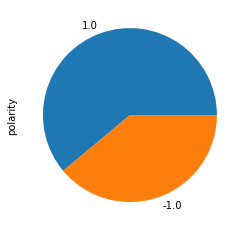

In [77]:
sentilex.polarity.value_counts().plot(kind='pie');

#### Top positive words

In [78]:
sentilex.sort_values('valence', ascending=False).head(10)

,polarity,valence
term_str,,
black,1.0,6.079303
rich,1.0,5.829653
drink,1.0,4.871027
years,1.0,4.665268
tannins,1.0,4.358166
ripe,1.0,3.910239
dark,1.0,3.792993
concentrated,1.0,3.745656
vineyard,1.0,3.564541


#### Top negative words

In [79]:
sentilex.sort_values('valence', ascending=True).head(10)

,polarity,valence
term_str,,
flavors,-1.0,-18.076629
aromas,-1.0,-8.754709
finish,-1.0,-8.642708
sweet,-1.0,-6.367219
simple,-1.0,-5.938595
soft,-1.0,-5.869761
green,-1.0,-4.806165
light,-1.0,-4.783091
like,-1.0,-3.877285


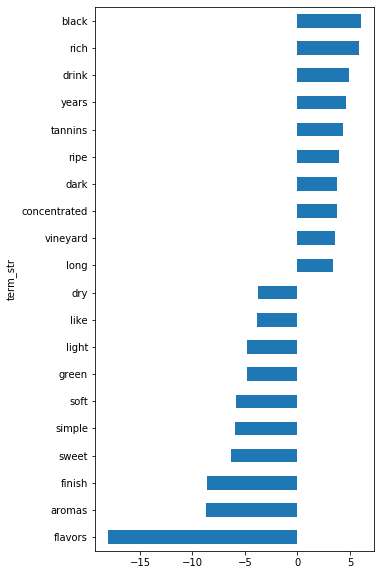

In [80]:
wpos = sentilex.valence.sort_values(ascending=False).head(10)
wneg = sentilex.valence.sort_values(ascending=False).tail(10)
pd.concat([wpos,wneg]).sort_values().plot.barh(figsize=(5,10));

### Expected Mutual Information

![](emi.png)

In [56]:
training_tokens.head()

,doc_id,term_id,doc_label
0,336,6485,N
1,336,6742,N
2,336,11737,N
3,336,990,N
4,336,10132,N


In [57]:
p_c = class_priors.to_frame()
p_c.columns = ['p']
p_c.index.name = 'doc_label'

In [58]:
p_c

,p
doc_label,
P,0.501689
N,0.498311


In [59]:
p_w = (training_tokens.term_id.value_counts() / training_tokens.shape[0]).to_frame()
p_w.columns = ['p']
p_w.index.name = 'term_id'
p_w['term_str'] = vocab.term_str

In [60]:
p_w.sort_values('p', ascending=False).head()

,p,term_str
term_id,,
15603,0.021406,wine
5588,0.019631,flavors
5927,0.013318,fruit
9961,0.011339,palate
990,0.010774,aromas


In [61]:
p_cw = training_tokens.groupby(['term_id','doc_label']).count() / training_tokens.shape[0]
p_cw.columns = ['p']

In [62]:
p_cw.head()

,,p
term_id,doc_label,
342,P,0.000012
345,P,0.000009
348,N,0.000009
350,P,0.000007
354,N,0.000002


In [63]:
EMI = training_tokens.join(p_cw, on=['term_id','doc_label'], how='left').rename(columns={'p':'p_cw'})
EMI = EMI.join(p_w['p'], on='term_id', how='left').rename(columns={'p':'p_w'})
EMI = EMI.join(p_c, on='doc_label', how='left').rename(columns={'p':'p_c'})
EMI = EMI.join(vocab['term_str'], on='term_id', how='left')
EMI['emi'] = EMI.p_cw * log(EMI.p_cw/(EMI.p_c * EMI.p_w))
EMI = EMI[['doc_label','term_id','term_str','emi']].drop_duplicates().set_index(['doc_label','term_id'])

In [64]:
VN = EMI.loc['N'].sort_values('emi', ascending=False).head(100)

In [65]:
VP = EMI.loc['P'].sort_values('emi', ascending=False).head(100)

In [66]:
VP.head(10)

,term_str,emi
term_id,,
1635,black,0.004288
4501,drink,0.004033
11643,rich,0.003759
13914,tannins,0.003631
11692,ripe,0.003182
15747,years,0.002934
15603,wine,0.002688
3877,dark,0.002460
3263,concentrated,0.002311


In [67]:
VN.head(10)

,term_str,emi
term_id,,
5588,flavors,0.003050
12642,simple,0.002249
13771,sweet,0.001431
12877,soft,0.001340
5493,finish,0.001290
13964,tastes,0.001280
6431,green,0.001243
8061,light,0.001237
990,aromas,0.001100
